# Load Forecasting
### 1. Data manipulation

Start by merging the load data and covariate data

In [82]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

In [120]:
# Read processed load data
base_dir = os.getcwd()
load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
load_data = pd.read_csv(load_file_path)
#print(load_data.head())

# Read processed temperature data
temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
avg_temperature_data = pd.read_csv(temperature_file_path)
#print(avg_temperature_data.head())

# Read processed humidity data
humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
avg_humidity_data = pd.read_csv(humidity_file_path)
#print(avg_humidity_data.head())

# Read processed solar irradiation data
solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
avg_solar_data = pd.read_csv(solar_file_path)
#print(avg_solar_data.head())

load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
data = load_data.copy()
data['temperature'] = avg_temperature_data['weighted_avg'].values
data['humidity'] = avg_humidity_data['weighted_avg'].values
data['solar'] = avg_solar_data['weighted_avg'].values
print(data)

                                Time (UTC)  Actual Total Load [MW] - BZN|SE4  \
0      01.01.2015 00:00 - 01.01.2015 01:00                            2267.0   
1      01.01.2015 01:00 - 01.01.2015 02:00                            2281.0   
2      01.01.2015 02:00 - 01.01.2015 03:00                            2313.0   
3      01.01.2015 03:00 - 01.01.2015 04:00                            2372.0   
4      01.01.2015 04:00 - 01.01.2015 05:00                            2424.0   
...                                    ...                               ...   
87667  31.12.2024 19:00 - 31.12.2024 20:00                            2414.0   
87668  31.12.2024 20:00 - 31.12.2024 21:00                            2313.0   
87669  31.12.2024 21:00 - 31.12.2024 22:00                            2231.0   
87670  31.12.2024 22:00 - 31.12.2024 23:00                            2219.0   
87671  31.12.2024 23:00 - 01.01.2025 00:00                            2168.0   

       temperature   humidity  solar  


In this section we implement the machine learning models. We start with our benchmark model which will later be used to compare the reaults of our 'advanced' models.

component            Actual Total Load [MW] - BZN|SE4
Timestamp                                            
2025-01-01 00:00:00                            2100.0
2025-01-01 01:00:00                            2089.0
2025-01-01 02:00:00                            2017.0
2025-01-01 03:00:00                            2050.0
2025-01-01 04:00:00                            2134.0
...                                               ...
2025-02-07 07:00:00                            2624.0
2025-02-07 08:00:00                            2636.0
2025-02-07 09:00:00                            2727.0
2025-02-07 10:00:00                            2835.0
2025-02-07 11:00:00                            2849.0

[900 rows x 1 columns]


<Axes: xlabel='Timestamp'>

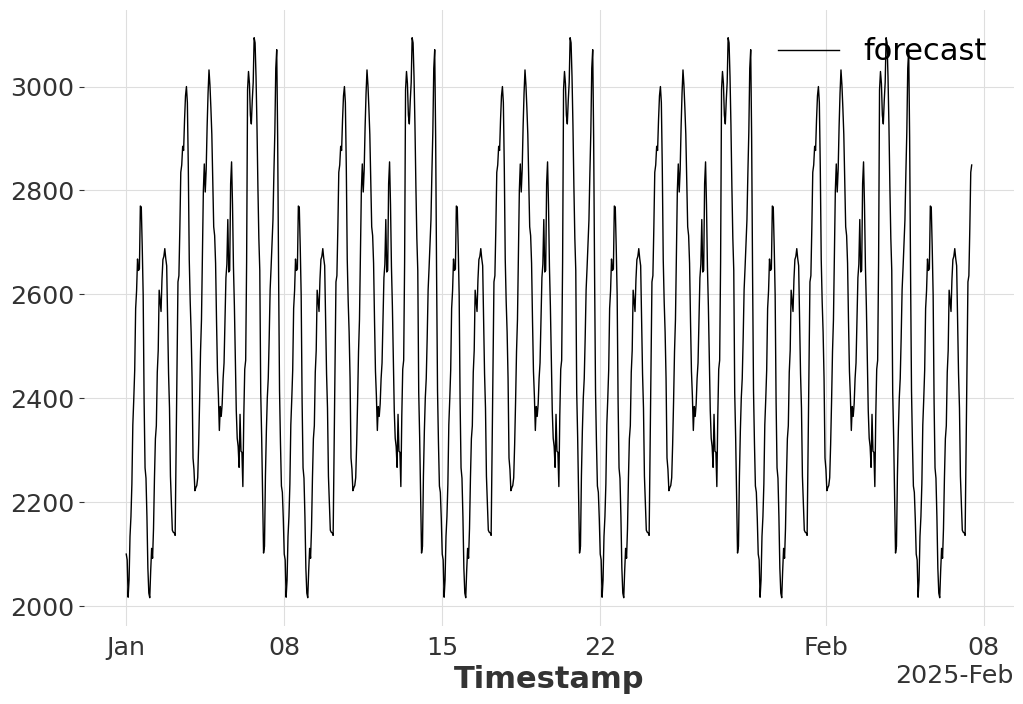

In [76]:
from darts.models import NaiveSeasonal
from darts import TimeSeries

#filepath = os.path.join("LoadData", "total_loadUTC_data.csv")
#data = pd.read_csv(filepath)
#data = pd.read_csv(filepath)

# Extract start timestamp (from "01.01.2015 00:00 - 01.01.2015 01:00")
load_data['Timestamp'] = pd.to_datetime(
    load_data['Time (UTC)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
)

# Set timestamp as index
load_data.set_index('Timestamp', inplace=True)

# Select one target column only (univariate series)
forecast_data = load_data['Actual Total Load [MW] - BZN|SE4']

# Create TimeSeries object
series = TimeSeries.from_series(forecast_data)

model = NaiveSeasonal(K=168) # weekly seasonality
model.fit(series)
pred = model.predict(900) # change this to number of hours to be plotted
print(pred.pd_dataframe())
pred.plot(label="forecast", lw=1)

Including holidays as covariate

In [121]:
import holidays

years = np.arange(2015, 2025)

raw_holidays = []
for date, name in sorted(holidays.Sweden(years=years).items()):
    if not name == "Söndag":
        raw_holidays.append(date)
        #print(date, name)
holiday_dates = set(raw_holidays)
print(holiday_dates)

{datetime.date(2017, 5, 1), datetime.date(2020, 10, 31), datetime.date(2020, 12, 24), datetime.date(2019, 1, 1), datetime.date(2022, 4, 17), datetime.date(2021, 6, 25), datetime.date(2022, 6, 6), datetime.date(2020, 6, 6), datetime.date(2018, 12, 25), datetime.date(2016, 12, 26), datetime.date(2018, 6, 23), datetime.date(2019, 5, 30), datetime.date(2019, 11, 2), datetime.date(2021, 12, 31), datetime.date(2015, 6, 6), datetime.date(2015, 5, 14), datetime.date(2023, 6, 23), datetime.date(2024, 5, 19), datetime.date(2022, 12, 31), datetime.date(2021, 4, 5), datetime.date(2016, 1, 6), datetime.date(2019, 4, 21), datetime.date(2018, 4, 2), datetime.date(2021, 5, 13), datetime.date(2015, 5, 24), datetime.date(2020, 4, 12), datetime.date(2024, 3, 31), datetime.date(2024, 1, 6), datetime.date(2024, 3, 29), datetime.date(2016, 5, 1), datetime.date(2020, 12, 31), datetime.date(2021, 1, 6), datetime.date(2021, 4, 4), datetime.date(2018, 5, 20), datetime.date(2020, 5, 31), datetime.date(2019, 12, 

Now merge all load and covariate data into one data frame

In [122]:
import datetime

## Alternative 1: minimal data frame, possibly bad for plotting
#data['is_holiday'] = data['Time (UTC)'].apply(
#    lambda x: datetime.datetime.strptime(x.split(' - ')[0], '%d.%m.%Y %H:%M').date() in holiday_dates
#).astype(int)

## Alternative 2: add start_time and end_time for plotting purposes
# Split time range into start and end
#data[['start_time', 'end_time']] = data['Time (UTC)'].str.split(' - ', expand=True)

# Convert to datetime
#data['start_time'] = pd.to_datetime(data['start_time'], format='%d.%m.%Y %H:%M')
#data['end_time'] = pd.to_datetime(data['end_time'], format='%d.%m.%Y %H:%M')
#data['is_holiday'] = data['start_time'].dt.date.isin(holiday_dates).astype(int)

# Alternative 3: simple timestamp instead of time range
data['Time (UTC)'] = pd.to_datetime(data['Time (UTC)'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
#print(data)
data['is_holiday'] = data['Time (UTC)'].dt.date.isin(holiday_dates).astype(int)

Starting with Gradient Boost Regressor 

In [ ]:
# XGBoost Load Forecasting Notebook
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# 📅 Feature Engineering
# Example lag and rolling features
#data['lag_hour'] = data['Actual Total Load [MW] - BZN|SE4'].shift(1)
#data['lag_day'] = data['Actual Total Load [MW] - BZN|SE4'].shift(24)
#data['lag_week'] = data['Actual Total Load [MW] - BZN|SE4'].shift(168)
#df['load_ma_7'] = df['load'].rolling(window=7).mean()
#print(data['Actual Total Load [MW] - BZN|SE4'])
#print(data['lag_day'])
# Datetime features

# Assuming `data` is your DataFrame and the `Time (UTC)` column is a datetime column
#data['Time (UTC)'] = pd.to_datetime(data['Time (UTC)'], format='%Y-%m-%d %H:%M:%S')

# Set the 'Time (UTC)' as the index of the DataFrame
#data.set_index('Time (UTC)', inplace=True)

#data['hour'] = data.index.hour
#print(data.head())
#data['dayofweek'] = data.index.dayofweek
#data['is_weekend'] = data['dayofweek'].isin([5, 6]).astype(int)

# Target variable (next-day forecast example)
#df['target'] = df['load'].shift(-24)

# Drop rows with NaNs from lagging/rolling
#df.dropna(inplace=True)

# Time-based train/test split
split_dates = ['2018-01-01','2019-01-01','2020-01-01','2023-01-01','2024-01-01']
train = pd.concat([
    data[:split_dates[0]],              # from start to 2018-01-01
    data[split_dates[2]:split_dates[3]] # from 2020-01-01 to 2022-01-01
])
print(train.head())
valid = pd.concat([
    data[split_dates[0]:split_dates[1]],# from 2018-01-01 to 2019-01-01
    data[split_dates[3]:split_dates[4]] # from 2022-01-01 to 2023-01-01
])
test = pd.concat([
    data[split_dates[1]:split_dates[2]],# from 2019-01-01 to 2020-01-01
    data[split_dates[4]:]               # from 2023-01-01 to end
])

# 🎯 Feature/target split
#features = [col for col in df.columns if col not in ['load', 'target']]
#X_train, y_train = train[features], train['target']
#X_test, y_test = test[features], test['target']

# ⚙️ Model Training
#model = xgb.XGBRegressor(
#    objective='reg:squarederror',
#    eval_metric='rmse',
#    random_state=123,
#    n_estimators=200,
#    max_depth=5,
#    subsample=0.8,
#    colsample_bytree=0.9,
#    learning_rate=0.05
#)

#model.fit(X_train, y_train)

# 📈 Evaluation
#y_pred = model.predict(X_test)
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print(f'RMSE: {rmse:.2f}')

# 📊 Plot actual vs predicted
#plt.figure(figsize=(12,6))
#plt.plot(y_test.index, y_test, label='Actual')
#plt.plot(y_test.index, y_pred, label='Predicted')
#plt.legend()
#plt.title('Load Forecast: Actual vs Predicted')
#plt.xlabel('Date')
#plt.ylabel('Load')
#plt.grid()
#plt.tight_layout()
#plt.show()

# 🧠 Feature Importance
#xgb.plot_importance(model, height=0.6, max_num_features=15)
#plt.title('Feature Importance')
#plt.show()

                     Actual Total Load [MW] - BZN|SE4  temperature   humidity  \
Time (UTC)                                                                      
2015-01-01 00:00:00                            2267.0     4.451320  86.611602   
2015-01-01 01:00:00                            2281.0     4.217264  85.613668   
2015-01-01 02:00:00                            2313.0     4.302403  85.022984   
2015-01-01 03:00:00                            2372.0     4.207889  86.857752   
2015-01-01 04:00:00                            2424.0     4.572334  85.142699   

                     solar  is_holiday  hour  dayofweek  is_weekend  
Time (UTC)                                                           
2015-01-01 00:00:00    0.0           1     0          3           0  
2015-01-01 01:00:00    0.0           1     1          3           0  
2015-01-01 02:00:00    0.0           1     2          3           0  
2015-01-01 03:00:00    0.0           1     3          3           0  
2015-01-01 0

In [125]:
print(data.head())
data.to_csv('data.csv')

                     Actual Total Load [MW] - BZN|SE4  temperature   humidity  \
Time (UTC)                                                                      
2015-01-01 00:00:00                            2267.0     4.451320  86.611602   
2015-01-01 01:00:00                            2281.0     4.217264  85.613668   
2015-01-01 02:00:00                            2313.0     4.302403  85.022984   
2015-01-01 03:00:00                            2372.0     4.207889  86.857752   
2015-01-01 04:00:00                            2424.0     4.572334  85.142699   

                     solar  is_holiday  hour  dayofweek  is_weekend  
Time (UTC)                                                           
2015-01-01 00:00:00    0.0           1     0          3           0  
2015-01-01 01:00:00    0.0           1     1          3           0  
2015-01-01 02:00:00    0.0           1     2          3           0  
2015-01-01 03:00:00    0.0           1     3          3           0  
2015-01-01 0